=== DATASET LOADING ===
Dataset shape: (20000, 13)

=== DATA TYPES ===
student_id            int64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object

=== FIRST 5 ROWS ===
   student_id  age  gender   course  study_hours  class_attendance  \
0           1   17    male  diploma         2.78              92.9   
1           2   23   other      bca         3.37              64.8   
2           3   22    male     b.sc         7.88              76.8   
3           4   20   other  diploma         0.67              48.4   
4           5   20  female  diploma         0.89              71.6   

  internet_access  sleep_hours sleep_quality   study_method facility_rating  \
0             yes          7.

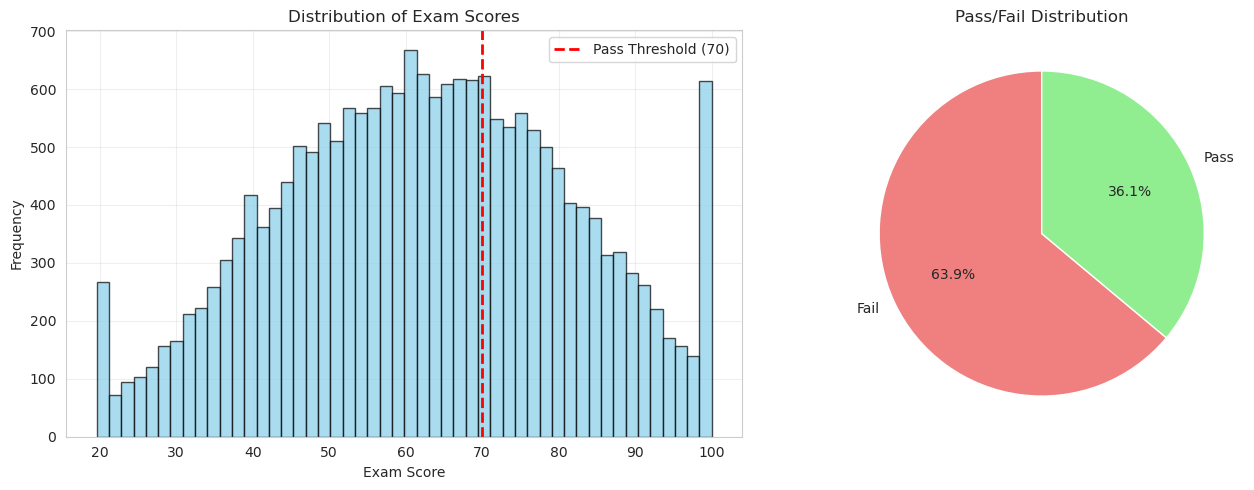


=== PREPARING FEATURES ===
Using 11 features:
 1. age
 2. study_hours
 3. class_attendance
 4. sleep_hours
 5. sleep_quality_numeric
 6. facility_rating_numeric
 7. exam_difficulty_numeric
 8. gender
 9. course
10. internet_access
11. study_method

Feature matrix shape: (20000, 11)
Target shape: (20000,)

Categorical features (4): ['gender', 'course', 'internet_access', 'study_method']
Numerical features (7): ['age', 'study_hours', 'class_attendance', 'sleep_hours', 'sleep_quality_numeric', 'facility_rating_numeric', 'exam_difficulty_numeric']

Train set: 16000 samples
Test set: 4000 samples
Train Pass rate: 0.361
Test Pass rate: 0.361
=== EXPLORATORY DATA ANALYSIS ===


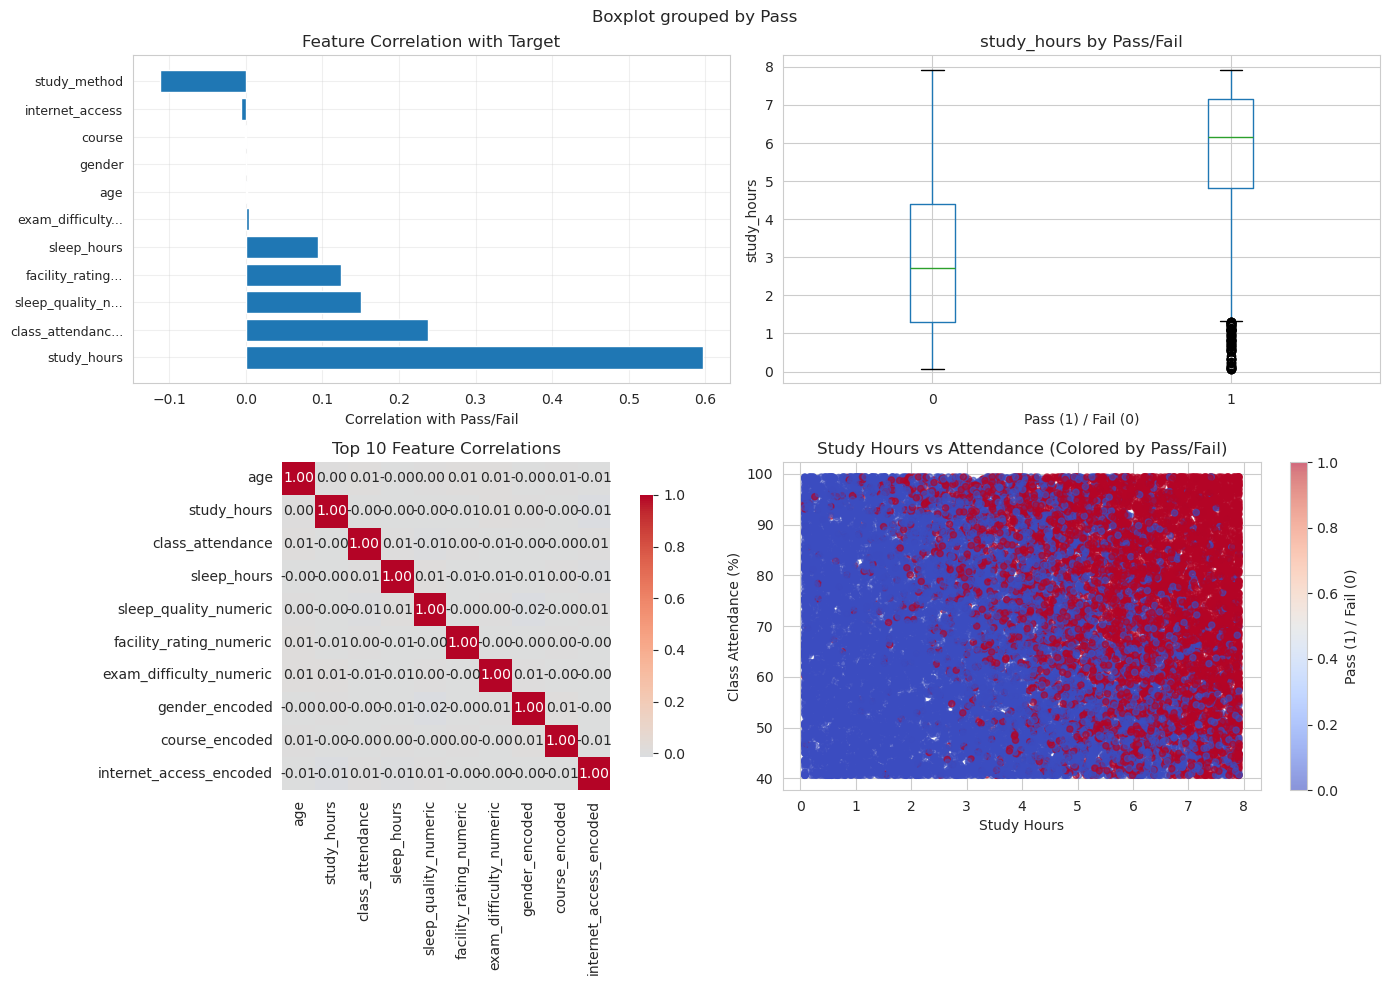


=== KEY INSIGHTS ===
Top 5 correlations with passing:
  study_hours: 0.596
  class_attendance: 0.238
  sleep_quality_numeric: 0.150
  facility_rating_numeric: 0.124
  sleep_hours: 0.095
=== CREATING PREPROCESSING PIPELINE ===
Preprocessing pipeline created successfully!
=== MODEL TRAINING ===

--- Training Logistic Regression ---
  CV Accuracy: 0.837 (±0.003)
  Test Accuracy: 0.840
  F1-Score: 0.795
  ROC-AUC: 0.928

--- Training Random Forest ---
  CV Accuracy: 0.833 (±0.005)
  Test Accuracy: 0.829
  F1-Score: 0.754
  ROC-AUC: 0.912

--- Training Gradient Boosting ---
  CV Accuracy: 0.841 (±0.004)
  Test Accuracy: 0.842
  F1-Score: 0.775
  ROC-AUC: 0.924


In [10]:
# %% [markdown]
# # 2.1 - Classification Problem
#
# **Dataset**: Exam Score Prediction Dataset
# **Source**: Kaggle (https://www.kaggle.com/datasets/kundanbedmutha/exam-score-prediction-dataset)
# **Original Objective**: Predict exam scores (regression)
# **Transformed Objective**: Classify students as PASS (score ≥ 70) or FAIL (score < 70)
#
# ## Problem Description
# This dataset contains academic, behavioral, lifestyle, and environmental factors for 20,000 students.
# By transforming the continuous exam score into a binary classification problem, we can build a model
# to predict whether a student will pass or fail based on their study habits and environment.

# %%
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_auc_score, roc_curve,
                           precision_recall_curve, f1_score)
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# %% [markdown]
# ## 1. Load and Inspect Dataset

# %%
print("=== DATASET LOADING ===")

# Load dataset
df = pd.read_csv('Exam_Score_Prediction.csv')

print(f"Dataset shape: {df.shape}")

# Check data types
print("\n=== DATA TYPES ===")
print(df.dtypes)

# Look at first few rows
print("\n=== FIRST 5 ROWS ===")
print(df.head())

# %% [markdown]
# ## 2. Fix Data Types - Critical Step!

# %%
print("=== FIXING DATA TYPES ===")

# Convert 'exam_score' from string to numeric
print("Converting 'exam_score' to numeric...")
df['exam_score'] = pd.to_numeric(df['exam_score'], errors='coerce')

# Check if there are any NaN values after conversion
nan_count = df['exam_score'].isna().sum()
print(f"NaN values in exam_score after conversion: {nan_count}")

if nan_count > 0:
    # Show rows with NaN exam scores
    print("\nRows with NaN exam scores:")
    print(df[df['exam_score'].isna()].head())
    
    # Fill NaN with median
    median_score = df['exam_score'].median()
    df['exam_score'] = df['exam_score'].fillna(median_score)
    print(f"Filled {nan_count} NaN values with median: {median_score:.1f}")

# Convert other columns if needed
# Convert 'internet_access' to boolean
print("\nConverting 'internet_access' to boolean...")
df['internet_access'] = df['internet_access'].map({'yes': True, 'no': False})

# Convert ordinal categorical variables to numeric
print("Converting ordinal categorical variables...")
sleep_quality_map = {'poor': 0, 'average': 1, 'good': 2}
facility_rating_map = {'low': 1, 'medium': 2, 'high': 3}
exam_difficulty_map = {'easy': 1, 'moderate': 2, 'hard': 3}

df['sleep_quality_numeric'] = df['sleep_quality'].map(sleep_quality_map)
df['facility_rating_numeric'] = df['facility_rating'].map(facility_rating_map)
df['exam_difficulty_numeric'] = df['exam_difficulty'].map(exam_difficulty_map)

# Check the results
print("\n=== VERIFYING CONVERSIONS ===")
print(f"exam_score dtype: {df['exam_score'].dtype}")
print(f"exam_score range: {df['exam_score'].min()} to {df['exam_score'].max()}")
print(f"\nSample converted values:")
print(df[['sleep_quality', 'sleep_quality_numeric', 
          'facility_rating', 'facility_rating_numeric',
          'exam_difficulty', 'exam_difficulty_numeric']].head())

# %% [markdown]
# ## 3. Create Binary Classification Target

# %%
print("\n=== CREATING BINARY TARGET VARIABLE ===")

# Define passing threshold
PASS_THRESHOLD = 70
print(f"Passing threshold: Score ≥ {PASS_THRESHOLD}")

# Create binary target
df['Pass'] = (df['exam_score'] >= PASS_THRESHOLD).astype(int)

# Analyze class distribution
class_dist = df['Pass'].value_counts()
print(f"\nClass distribution:")
print(f"  Fail (0): {class_dist.get(0, 0)} samples ({class_dist.get(0, 0)/len(df)*100:.1f}%)")
print(f"  Pass (1): {class_dist.get(1, 0)} samples ({class_dist.get(1, 0)/len(df)*100:.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['exam_score'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(PASS_THRESHOLD, color='red', linestyle='--', linewidth=2, 
                label=f'Pass Threshold ({PASS_THRESHOLD})')
axes[0].set_xlabel('Exam Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Exam Scores')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Pie chart
axes[1].pie(class_dist.values, labels=['Fail', 'Pass'], autopct='%1.1f%%',
            colors=['lightcoral', 'lightgreen'], startangle=90)
axes[1].set_title('Pass/Fail Distribution')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 4. Prepare Features for Modeling

# %%
print("\n=== PREPARING FEATURES ===")

# Define which columns to use as features
# We'll use the numeric versions of ordinal variables we created
feature_cols = [
    'age',
    'study_hours',
    'class_attendance',
    'sleep_hours',
    'sleep_quality_numeric',
    'facility_rating_numeric',
    'exam_difficulty_numeric',
    'gender',  # nominal categorical
    'course',  # nominal categorical
    'internet_access',  # boolean
    'study_method'  # nominal categorical
]

print(f"Using {len(feature_cols)} features:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

# Create feature matrix and target
X = df[feature_cols]
y = df['Pass']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Identify feature types
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train Pass rate: {y_train.mean():.3f}")
print(f"Test Pass rate: {y_test.mean():.3f}")

# %% [markdown]
# ## 5. Exploratory Data Analysis

# %%
print("=== EXPLORATORY DATA ANALYSIS ===")

# Create a copy for EDA with encoded categoricals
X_eda = X.copy()
y_eda = y.copy()

# Encode categorical variables for correlation analysis
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_eda[f'{col}_encoded'] = le.fit_transform(X_eda[col].astype(str))
    label_encoders[col] = le

# Combine all features for correlation
eda_features = numerical_features + [f'{col}_encoded' for col in categorical_features]
eda_df = pd.concat([X_eda[eda_features], y_eda], axis=1)

# Correlation matrix
corr_matrix = eda_df.corr()

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Correlation with target
target_corr = corr_matrix['Pass'].drop('Pass').sort_values(ascending=False)
axes[0,0].barh(range(len(target_corr)), target_corr.values)
axes[0,0].set_yticks(range(len(target_corr)))
display_names = [name.replace('_encoded', '') for name in target_corr.index]
display_names = [name[:15] + '...' if len(name) > 15 else name for name in display_names]
axes[0,0].set_yticklabels(display_names, fontsize=9)
axes[0,0].set_xlabel('Correlation with Pass/Fail')
axes[0,0].set_title('Feature Correlation with Target')
axes[0,0].grid(True, alpha=0.3)

# 2. Top 3 features vs Pass
top_features = target_corr.abs().sort_values(ascending=False).index[:3]
for i, feature in enumerate(top_features):
    if feature in X.columns:
        df_temp = pd.DataFrame({feature: X[feature], 'Pass': y})
        df_temp.boxplot(column=feature, by='Pass', ax=axes[0,1])
        axes[0,1].set_title(f'{feature} by Pass/Fail')
        axes[0,1].set_xlabel('Pass (1) / Fail (0)')
        axes[0,1].set_ylabel(feature)
        break

# 3. Heatmap of top correlations
top_n = min(10, len(corr_matrix))
top_corr = corr_matrix.iloc[:top_n, :top_n]
sns.heatmap(top_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=axes[1,0], cbar_kws={'shrink': 0.8})
axes[1,0].set_title(f'Top {top_n} Feature Correlations')

# 4. Study hours vs Attendance by Pass/Fail
if 'study_hours' in X.columns and 'class_attendance' in X.columns:
    scatter = axes[1,1].scatter(X['study_hours'], X['class_attendance'], 
                               c=y, alpha=0.6, cmap='coolwarm', s=20)
    axes[1,1].set_xlabel('Study Hours')
    axes[1,1].set_ylabel('Class Attendance (%)')
    axes[1,1].set_title('Study Hours vs Attendance (Colored by Pass/Fail)')
    plt.colorbar(scatter, ax=axes[1,1], label='Pass (1) / Fail (0)')

plt.tight_layout()
plt.show()

# Print insights
print("\n=== KEY INSIGHTS ===")
print("Top 5 correlations with passing:")
for feature, corr in target_corr.head(5).items():
    feature_name = feature.replace('_encoded', '')
    print(f"  {feature_name}: {corr:.3f}")

# %% [markdown]
# ## 6. Create Preprocessing Pipeline

# %%
print("=== CREATING PREPROCESSING PIPELINE ===")

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessing pipeline created successfully!")

# %% [markdown]
# ## 7. Model Training and Comparison
# 
# [Continue with the rest of your original code from here...]

# %%
print("=== MODEL TRAINING ===")

# Define models with preprocessing
models = {
    'Logistic Regression': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
    ]),
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
    ]),
    'Gradient Boosting': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ])
}

# Train and evaluate models
results = {}
for name, pipeline in models.items():
    print(f"\n--- Training {name} ---")
    
    try:
        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                    cv=5, scoring='accuracy', n_jobs=-1)
        
        # Train on full training set
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        results[name] = {
            'pipeline': pipeline,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'accuracy': accuracy,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        print(f"  CV Accuracy: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
        print(f"  Test Accuracy: {accuracy:.3f}")
        print(f"  F1-Score: {f1:.3f}")
        print(f"  ROC-AUC: {roc_auc:.3f}")
        
    except Exception as e:
        print(f"  Error training {name}: {str(e)[:100]}...")
        continue

# Now you can continue with the rest of your original notebook...
# The rest of your code (hyperparameter tuning, evaluation, etc.) should work now